In [24]:
# This script needs these libraries to be installed: 
#   numpy, xgboost

import wandb
from wandb.xgboost import WandbCallback
import numpy as np
import xgboost as xgb
import joblib
import zipfile
import os
from utils import break_datetime
import warnings
import holidays
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import itertools
import matplotlib.dates as mdates
import pandas as pd


warnings.filterwarnings('ignore')


# Loading data

In [2]:
# Specify the ZIP file name
zip_filename = "../dataset/filtered.zip"

# Extract the model file from the ZIP archive
with zipfile.ZipFile(zip_filename, "r") as archive:
    # Extract the model file (named "your_model.pkl" in this example)
    archive.extract("filtered.pkl")
    
# Load the model
df = joblib.load("filtered.pkl")  # Replace with "pickle.load" if you used pickle

os.remove("filtered.pkl")

df = df[df['site_id'].isin([1, 6])]
df['log_meter_reading']=np.log1p(df['meter_reading'])
df['log_square_feet']=np.log1p(df['square_feet'])
df= break_datetime(df)
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,sea_level_pressure,wind_direction,wind_speed,log_meter_reading,log_square_feet,year,weekofyear,dayofweek,month,hour
3,105,0,2016-01-01,23.3036,1,Education,50623,NaN,5.0,3.8,...,1020.9,240.0,3.1,3.190624,10.832181,2015,53,5,1,0
4,106,0,2016-01-01,0.3746,1,Education,5374,NaN,4.0,3.8,...,1020.9,240.0,3.1,0.318163,8.589514,2015,53,5,1,0
5,107,0,2016-01-01,175.1840,1,Education,97532,2005.0,10.0,3.8,...,1020.9,240.0,3.1,5.171529,11.487946,2015,53,5,1,0
6,108,0,2016-01-01,91.2653,1,Education,81580,1913.0,5.0,3.8,...,1020.9,240.0,3.1,4.524668,11.309352,2015,53,5,1,0
7,109,0,2016-01-01,80.9300,1,Education,56995,1953.0,6.0,3.8,...,1020.9,240.0,3.1,4.405865,10.950736,2015,53,5,1,0


In [3]:
# Circular encoding function
def circular_encode(feature, max_value):
    sin_encoded = np.sin(2 * np.pi * feature / max_value)
    cos_encoded = np.cos(2 * np.pi * feature / max_value)
    return sin_encoded, cos_encoded

# Apply circular encoding to the timestamp features
df['month_sin'], df['month_cos'] = circular_encode(df['month'], 12)
df['hour_sin'], df['hour_cos'] = circular_encode(df['hour'], 24)
df['dayofweek_sin'], df['dayofweek_cos'] = circular_encode(df['dayofweek'], 7)

In [4]:
label_enc= LabelEncoder()
label_enc.fit(df['primary_use'])
df['primary_use_encoded'] = label_enc.transform(df['primary_use'])
df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,dayofweek,month,hour,month_sin,month_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,primary_use_encoded
3,105,0,2016-01-01 00:00:00,23.3036,1,Education,50623,NaN,5.0,3.8,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0
4,106,0,2016-01-01 00:00:00,0.3746,1,Education,5374,NaN,4.0,3.8,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0
5,107,0,2016-01-01 00:00:00,175.1840,1,Education,97532,2005.0,10.0,3.8,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0
6,108,0,2016-01-01 00:00:00,91.2653,1,Education,81580,1913.0,5.0,3.8,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0
7,109,0,2016-01-01 00:00:00,80.9300,1,Education,56995,1953.0,6.0,3.8,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11530119,782,0,2016-12-31 23:00:00,439.7170,6,Education,129344,NaN,NaN,7.2,...,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0
11530120,784,0,2016-12-31 23:00:00,503.0830,6,Education,190817,NaN,NaN,7.2,...,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0
11530121,785,0,2016-12-31 23:00:00,921.1470,6,Education,250000,NaN,NaN,7.2,...,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0
11530122,787,0,2016-12-31 23:00:00,154.1330,6,Lodging/residential,278795,NaN,NaN,7.2,...,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,2


In [5]:
df['is_weekday']=df['dayofweek'] <= 5
df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,month,hour,month_sin,month_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,primary_use_encoded,is_weekday
3,105,0,2016-01-01 00:00:00,23.3036,1,Education,50623,NaN,5.0,3.8,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True
4,106,0,2016-01-01 00:00:00,0.3746,1,Education,5374,NaN,4.0,3.8,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True
5,107,0,2016-01-01 00:00:00,175.1840,1,Education,97532,2005.0,10.0,3.8,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True
6,108,0,2016-01-01 00:00:00,91.2653,1,Education,81580,1913.0,5.0,3.8,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True
7,109,0,2016-01-01 00:00:00,80.9300,1,Education,56995,1953.0,6.0,3.8,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11530119,782,0,2016-12-31 23:00:00,439.7170,6,Education,129344,NaN,NaN,7.2,...,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False
11530120,784,0,2016-12-31 23:00:00,503.0830,6,Education,190817,NaN,NaN,7.2,...,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False
11530121,785,0,2016-12-31 23:00:00,921.1470,6,Education,250000,NaN,NaN,7.2,...,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False
11530122,787,0,2016-12-31 23:00:00,154.1330,6,Lodging/residential,278795,NaN,NaN,7.2,...,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,2,False


In [6]:
# Load holiday data for England
england_holidays = holidays.UnitedKingdom(years=range(2016, 2017))

# Load holiday data for the United States
us_holidays = holidays.UnitedStates(years=range(2016, 2017))

# Initialize 'is_holiday' column with zeros
df['is_holiday'] = 0

# Create 'is_holiday_england' feature
england_mask = df['site_id'] == 1
df.loc[england_mask, 'is_holiday'] = df.loc[england_mask, 'timestamp'].apply(lambda x: 1 if x in england_holidays else 0)

# Create 'is_holiday_us' feature
us_mask = df['site_id'] == 6
df.loc[us_mask, 'is_holiday'] = df.loc[us_mask, 'timestamp'].apply(lambda x: 1 if x in us_holidays else 0)

df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,hour,month_sin,month_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,primary_use_encoded,is_weekday,is_holiday
3,105,0,2016-01-01 00:00:00,23.3036,1,Education,50623,NaN,5.0,3.8,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True,1
4,106,0,2016-01-01 00:00:00,0.3746,1,Education,5374,NaN,4.0,3.8,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True,1
5,107,0,2016-01-01 00:00:00,175.1840,1,Education,97532,2005.0,10.0,3.8,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True,1
6,108,0,2016-01-01 00:00:00,91.2653,1,Education,81580,1913.0,5.0,3.8,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True,1
7,109,0,2016-01-01 00:00:00,80.9300,1,Education,56995,1953.0,6.0,3.8,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11530119,782,0,2016-12-31 23:00:00,439.7170,6,Education,129344,NaN,NaN,7.2,...,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False,0
11530120,784,0,2016-12-31 23:00:00,503.0830,6,Education,190817,NaN,NaN,7.2,...,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False,0
11530121,785,0,2016-12-31 23:00:00,921.1470,6,Education,250000,NaN,NaN,7.2,...,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False,0
11530122,787,0,2016-12-31 23:00:00,154.1330,6,Lodging/residential,278795,NaN,NaN,7.2,...,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,2,False,0


In [7]:
df=df.sort_values(by='timestamp')

In [8]:
features = ['hour_sin','hour_cos','is_weekday','month_sin','month_cos','log_square_feet', 'primary_use_encoded']
target = 'log_meter_reading'

# Create WandB Project

In [9]:
wandb.init(project='XGB', entity='foresquad')

# Define the hyperparameter values for grid search
max_depth_values = [3, 5, 8]
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.05, 0.1]

# Perform grid search
best_params = None
best_mse = float('inf')

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(max_depth_values, n_estimators_values, learning_rate_values))

for params in hyperparameter_combinations:
    max_depth, n_estimators, learning_rate = params

    # Split data for time series
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize metrics
    mse_scores = []

    # Perform time series cross-validation
    for train_index, val_index in tscv.split(df):
        train_data, val_data = df.iloc[train_index], df.iloc[val_index]
        X_train, y_train = train_data[features], train_data[target]
        X_val, y_val = val_data[features], val_data[target]

        # Train XGBoost model
        model = xgb.XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            objective='reg:squarederror'  # Specify the appropriate objective for regression
        )
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

        # Make predictions
        y_pred = model.predict(X_val)

        # Calculate mean squared error
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    # Compute the average MSE over folds
    average_mse = sum(mse_scores) / len(mse_scores)

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate, "mse": average_mse})

    # Update best hyperparameters if current configuration is better
    if average_mse < best_mse:
        best_mse = average_mse
        best_params = {"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate}

# Log the best hyperparameters and metrics after grid search
wandb.log({"Best Hyperparameters": best_params, "Best Mean Squared Error": best_mse})
wandb.finish()  # Finish the W&B run to ensure logs are flushed before the script exits


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guzunturk94 (foresquad). Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Mean Squared Error,▁
learning_rate,▁█▁█▁█▁█▁█▁█▁█▁█▁█
max_depth,▁▁▁▁▁▁▄▄▄▄▄▄██████
mse,█▅▅▃▄▂▄▂▂▁▁▁▃▁▁▁▁▁
n_estimators,▁▁▅▅██▁▁▅▅██▁▁▅▅██
Best Mean Squared Error,0.25557
learning_rate,0.1
max_depth,8
mse,0.26796
n_estimators,150


In [ ]:
wandb.init(project='XGB_Grid_Search', entity='foresquad')

# Define the hyperparameter values for grid search
max_depth_values = [3, 5, 8]
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.05, 0.1]

# Perform grid search
best_params = None
best_mse = float('inf')

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(max_depth_values, n_estimators_values, learning_rate_values))

for params in hyperparameter_combinations:
    max_depth, n_estimators, learning_rate = params

    # Split data for time series
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize metrics
    mse_scores = []

    # Perform time series cross-validation
    for train_index, val_index in tscv.split(df):
        train_data, val_data = df.iloc[train_index], df.iloc[val_index]
        X_train, y_train = train_data[features], train_data[target]
        X_val, y_val = val_data[features], val_data[target]

        # Train XGBoost model
        model = xgb.XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            objective='reg:squarederror'  # Specify the appropriate objective for regression
        )
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

        # Make predictions
        y_pred = model.predict(X_val)

        # Calculate mean squared error
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    # Compute the average MSE over folds
    average_mse = sum(mse_scores) / len(mse_scores)

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate, "mse": average_mse})

    # Update best hyperparameters if current configuration is better
    if average_mse < best_mse:
        best_mse = average_mse
        best_params = {"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate}

# Log the best hyperparameters and metrics after grid search
wandb.log({"Best Hyperparameters": best_params, "Best Mean Squared Error": best_mse})
wandb.finish()  # Finish the W&B run to ensure logs are flushed before the script exits


fold : 1
Train:  2016-01-01 00:00:00 2016-03-02 02:00:00
Test:  2016-03-02 02:00:00 2016-05-02 02:00:00


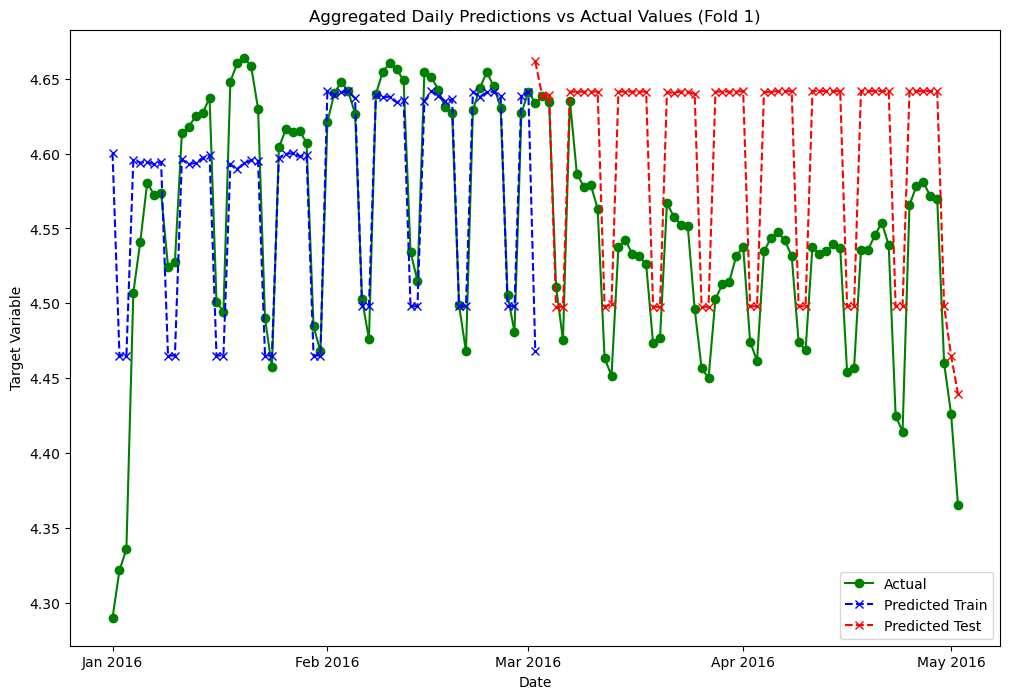

fold : 2
Train:  2016-01-01 00:00:00 2016-05-02 02:00:00
Test:  2016-05-02 02:00:00 2016-07-02 00:00:00


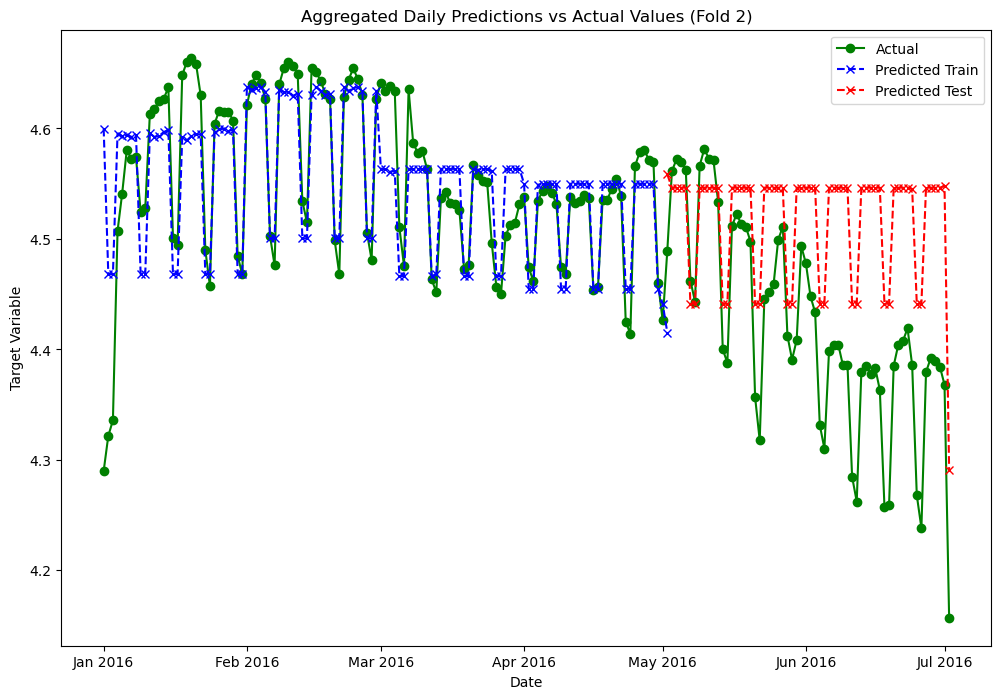

fold : 3
Train:  2016-01-01 00:00:00 2016-07-02 00:00:00
Test:  2016-07-02 00:00:00 2016-09-01 00:00:00


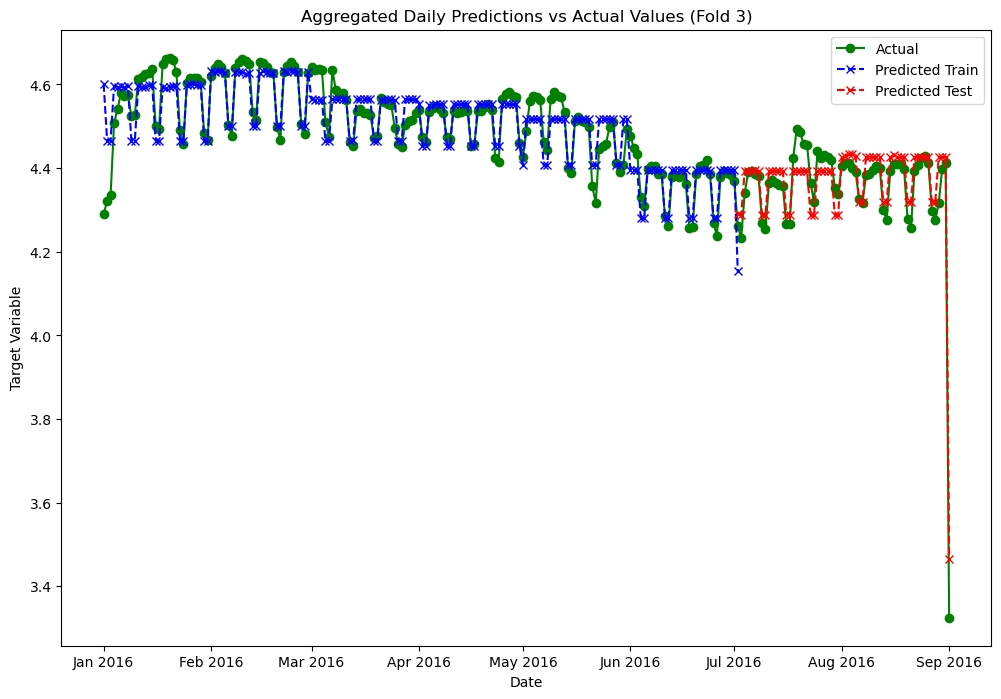

fold : 4
Train:  2016-01-01 00:00:00 2016-09-01 00:00:00
Test:  2016-09-01 00:00:00 2016-10-31 22:00:00


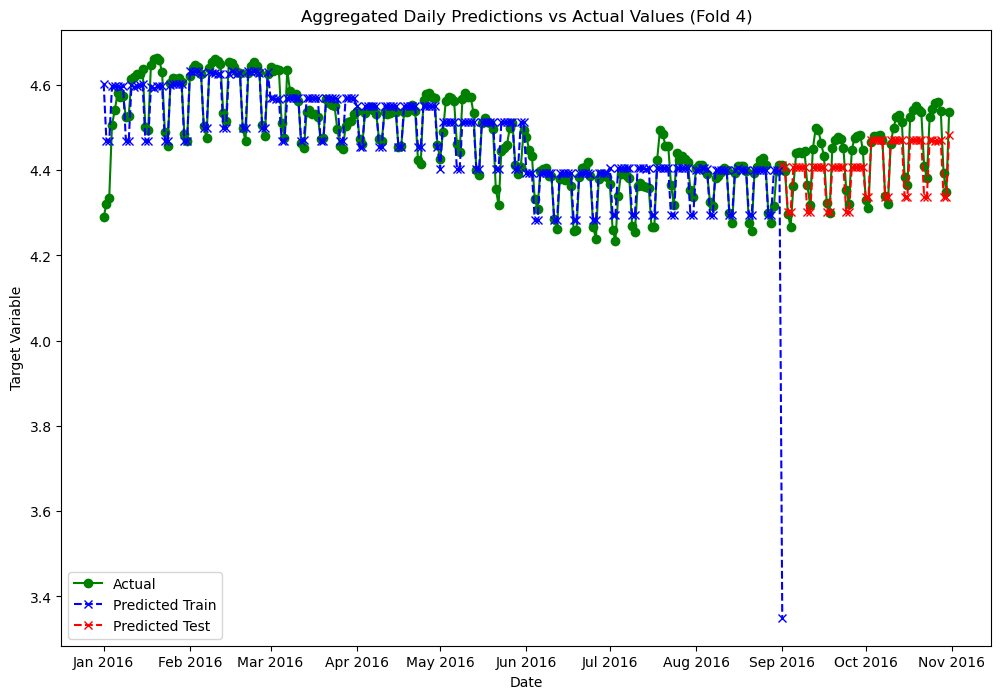

fold : 5
Train:  2016-01-01 00:00:00 2016-10-31 22:00:00
Test:  2016-10-31 22:00:00 2016-12-31 23:00:00


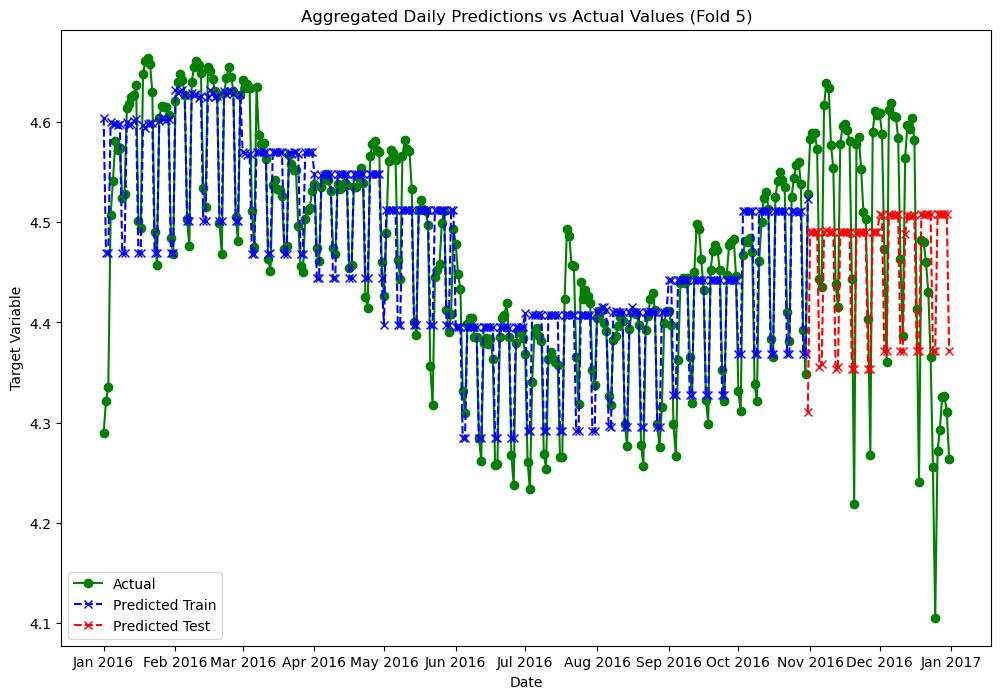

In [30]:
i = 1  # Start fold index from 1

for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ', df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ', df_test['timestamp'].min(), df_test['timestamp'].max()) 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = xgb.XGBRegressor(
        objective='reg:squarederror',  # Use 'reg:squarederror' for regression problems
        n_estimators=150,               # Number of boosting rounds (adjust as needed)
        learning_rate=0.1,              # Step size shrinkage to prevent overfitting
        max_depth=5                     # Maximum depth of each tree (adjust as needed)
    )

    XGB.fit(X_train, y_train)
    
    y_pred_train = XGB.predict(X_train)
    y_pred_test = XGB.predict(X_test)

    # DataFrames to store aggregated values for the current fold
    aggregated_actual_df = pd.concat([pd.DataFrame({'timestamp': df_train['timestamp'], 'actual': y_train}),
                                      pd.DataFrame({'timestamp': df_test['timestamp'], 'actual': y_test})])

    aggregated_predicted_df = pd.concat([pd.DataFrame({'timestamp': df_train['timestamp'], 'predicted_train': y_pred_train}),
                                         pd.DataFrame({'timestamp': df_test['timestamp'], 'predicted_test': y_pred_test})])

    # Group by timestamp and resample on a daily basis
    aggregated_actual_df.set_index('timestamp', inplace=True)
    aggregated_predicted_df.set_index('timestamp', inplace=True)

    aggregated_actual_daily = aggregated_actual_df.resample('D').mean()
    aggregated_predicted_daily = aggregated_predicted_df.resample('D').mean()

    # Plotting aggregated daily predictions for the current fold
    plt.figure(figsize=(12, 8))
    plt.plot(aggregated_actual_daily.index, aggregated_actual_daily['actual'], label='Actual', marker='o', color='green')
    plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_train'], label='Predicted Train', marker='x', linestyle='--', color='blue')
    plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_test'], label='Predicted Test', marker='x', linestyle='--', color='red')
    plt.title(f'Aggregated Daily Predictions vs Actual Values (Fold {i})')
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.legend()
    # Format x-axis ticks as months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())    

    plt.show()

    i += 1  # Increment the fold index


In [ ]:
i = 0
for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ',df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ',df_test['timestamp'].min(), df_test['timestamp'].max()) 
    i = i + 1 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression problems
    n_estimators=150,               # Number of boosting rounds (adjust as needed)
    learning_rate=0.1,              # Step size shrinkage to prevent overfitting
    max_depth=5                     # Maximum depth of each tree (adjust as needed)
    )


    XGB.fit(X_train,y_train)
    
    y_pred_train = XGB.predict(X_train)
    y_pred_test = XGB.predict(X_test)

    # DataFrames to store aggregated values for all folds
    aggregated_actual_df = pd.DataFrame()
    aggregated_predicted_df = pd.DataFrame()

    #Add timestamp and predictions to DataFrames
    aggregated_actual_df = pd.concat([aggregated_actual_df, pd.DataFrame({'timestamp': df_train['timestamp'], 'actual': y_train})])
    aggregated_predicted_df = pd.concat([aggregated_predicted_df, pd.DataFrame({'timestamp': df_train['timestamp'], f'predicted_fold_{i}': y_pred_train})])
    
    # Group by timestamp and resample on a daily basis
    aggregated_actual_df.set_index('timestamp', inplace=True)
    aggregated_predicted_df.set_index('timestamp', inplace=True)

    aggregated_actual_daily = aggregated_actual_df.resample('D').mean()
    aggregated_predicted_daily = aggregated_predicted_df.resample('D').mean()

    # Plotting aggregated daily predictions for all folds
    plt.figure(figsize=(10, 6))
    plt.plot(aggregated_actual_daily.index, aggregated_actual_daily['actual'], label='Actual (Aggregated)', marker='o')
    plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily[f'predicted_fold_{i}'], label=f'Predicted Fold {i} (Aggregated)', marker='x')
    plt.title('Aggregated Daily Predictions vs Actual Values (Training Set)')
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.legend()
    # Format x-axis ticks as months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())    

    plt.show()

  

# Save model for best hyperparameters and trained for last fold

In [16]:
print('Train: ',train_data['timestamp'].min(), train_data['timestamp'].max()) 
print('Test: ',val_data['timestamp'].min(), val_data['timestamp'].max()) 

Train:  2016-01-01 00:00:00 2016-10-31 22:00:00
Test:  2016-10-31 22:00:00 2016-12-31 23:00:00


In [17]:
model = xgb.XGBRegressor(
    max_depth=5,
    n_estimators=150,
    learning_rate=0.1,
    objective='reg:squarederror'  # Specify the appropriate objective for regression
)

In [20]:
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
train_error_mse = mean_squared_error(y_train,y_pred_train)
train_error_r2 = r2_score(y_train,y_pred_train)
train_error_mape = mean_absolute_percentage_error(y_train,y_pred_train)
train_error_mae = mean_absolute_error(y_train,y_pred_train)

print("MSE for train set is: ",train_error_mse)

print("R2 for train set is: ",train_error_r2)

print("MAPE for train set is: ",train_error_mape)

print("MAE for train set is: ",train_error_mae)

y_pred_test = model.predict(X_val)
test_error_mse = mean_squared_error(y_val,y_pred_test)
test_error_r2 = r2_score(y_val,y_pred_test)
test_error_mape = mean_absolute_percentage_error(y_val,y_pred_test)
test_error_mae = mean_absolute_error(y_val,y_pred_test)

print("MSE for test set is: ",test_error_mse)

print("R2 for test set is: ",test_error_r2)

print("MAPE for test set is: ",test_error_mape)

print("MAE for test set is: ",test_error_mae)


MSE for train set is:  0.060194606864386956
R2 for train set is:  0.9634018602666107
MAPE for train set is:  0.5413800942950852
MAE for train set is:  0.14793636680417768
MSE for test set is:  0.6152887253767226
R2 for test set is:  0.5697844709386588
MAPE for test set is:  1.4189895738760374
MAE for test set is:  0.3128089830757826


In [22]:
# Specify the zip file name
zip_filename = "../models/XGB_v1.zip"

# Create a ZIP file and add the model object to it
with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as archive:
    # Save the model to a temporary file
    temp_model_filename = "temp_model.pkl"
    joblib.dump(model, temp_model_filename)
    
    # Add the temporary model file to the ZIP archive
    archive.write(temp_model_filename, arcname="XGB_v1.pkl")

# Remove the temporary model file
os.remove(temp_model_filename)